In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz
from utils import sample_PLN
import scipy.linalg as SLA
import torch.linalg as TLA
import scipy
from fastPLN import fastPLN
from scipy.special import factorial
import math
import seaborn as sns 
import torch 
from pandas import read_csv
import time
#torch.set_default_dtype(torch.float64)

device :  cpu


In [2]:
%load_ext autoreload

%autoreload 2

$$
\begin{aligned}
W_{i} & \sim \mathcal{N}\left(0, I_{q}\right), \text { iid, } \quad i=1, \ldots, n \\
Z_{i} &=\mathbf{x}_{i}\beta +W_{i}\mathbf{C}^{\top}, \quad i \in 1, \ldots, n \\
Y_{i j} \mid Z_{i j} & \sim \mathcal{P}\left(\exp \left(o_{i j}+Z_{i j}\right)\right)
\end{aligned}
$$

We want to maximize the likelihood with respect to $\theta$ : 


$$\max _{\theta} P_{\theta}(Y)$$

But we need to integrate out $W$ in order to compute the quantity inside the max : 

$$
\begin{aligned}
P_{\theta}\left(Y_{i}\right) &=\int P_{\theta}\left(Y_{i}, W\right) d W \\
&=\int P_{\theta}\left(Y_{i} \mid W\right) p(W) d W
\end{aligned}
$$

This integral being untractable, we are going to approximate it with Monte Carlo methods : 

$$
\int p_{\theta}\left(Y_{i} \mid W\right) p(W) d W \approx \frac{1}{K} \sum_{k = 1 }^Kp_{\theta}\left(Y_{i} \mid W_{i,k}\right) p\left(W_{i,k}\right)
$$
$$W_{i,k} \sim \mathcal N (0, I_q)$$

The larger the $K$ the better the approximation.  

Let's compute $p_{\theta}\left(Y_{i} \mid W_{i,k}\right) p\left(W_{i,k}\right)$. 


First, 

$$
P\left(W_{i,k}\right)=\frac{1}{\sqrt{2 \pi}} \exp \left(-\frac{1}{2}\left\|W_{i,k}\right\|_{2}^{2}\right)
$$ 

Then, 

$$
\begin{aligned}
P_{\theta}\left(Y_{i} \mid W_{i,k}\right) &=\prod_{j=1}^{p} p_{\theta}\left(Y_{i j} \mid W_{i,k}\right) \\
&=\prod_{j=1}^{P} \frac{1}{Y_{i j} !} \exp \left(-\exp \left(o_{i j}+z_{i j}\right)\right) \exp \left(o_{i j}+z_{i j}\right)^{Y_{ij}}
\end{aligned}
$$
$$
Z_{i j}=x_{i}^{\top} \beta_{j}+W_{i,k}^{\top} C^{\top} _{j}
$$

For numerical purposes, we may want to use a logarithmic scale and apply the exponential function after. Indeed, $Y_{ij}$ can go up to a thousand, and computing this factorial would give infinite values. 

$$
\log p_{\theta}\left(Y_{i} \mid W_{i,k}\right)=\sum_{j=1}^{p} - \ln \left(Y_{i j} !\right)-\exp \left(0_{i j}+Z_{i j}\right)+Y_{i j}\left(o_{i j}+Z_{i j}\right)
$$

If we consider the whole likelihood : 

$$
\begin{aligned}
\ln p_{\theta}\left(Y \mid W_{k}\right) &=\sum_{i=1}^{n} \log p_{\theta}\left(Y_{i} \mid W_{i k}\right) \\
&=\sum_{i=1}^{n} \sum_{j} - \ln \left(Y_{ij} ! \right)-\exp \left(0_{i j}+Z_{i j}\right)+Y_{i j}\left(0_{i j}+Z_{i j}\right) \\
&=1_{n}^{T}\left[-\ln (Y !)-\exp (0+Z)+Y \odot (0+Z)\right] 1_{p} \\
Z=& X \beta+W_{k} C^{\top}
\end{aligned}
$$

We are going tu use the Stirling Formula in order to compute the log of the factorial, to avoid computing directly the factorial.  

We now need to compute the gradients. Since 

$$
\nabla_{\theta} p_{\theta}\left(Y_{i} \mid W_{i,k}\right)=p_{\theta}\left(Y_{i}| W_{i,k}\right) \nabla_{\theta} \log p_{\theta}\left(Y_{i} \mid W_{i,k}\right)
$$

We get : 

$$
\nabla_{\beta} p_{\theta}\left(Y_{i} \mid W_{i,k}\right)=p_{\theta}\left(Y_{i} \mid W_{i,k}\right)\left[-x_{i}^{\top} \exp \left(0_{i}+x_{i}^{\top} \beta+W_{i,k}^{\top} C^{\top}\right)+ x_{i}^{\top}Y_i\right]
$$
$$
\nabla_{C} p_{\theta}\left(Y_{i} \mid W_{i,k}\right)=p_{\theta}\left(Y_{i} \mid W_{i,k}\right)\left[-W_{i,k}^{\top} \exp \left(0_{i}+x_{i}^{\top} \beta+W_{i,k}^{\top} C^{\top}\right)+ W_{i,k}^{\top}Y_i\right]
$$
This is if we take only one sample $Y_i$. If we take the whole dataset (or a mini-batch), we get (writed in matrix form) :

$$
\nabla_{\beta} p_{\theta}\left(Y \mid W_k\right)=p_{\theta}\left(Y \mid W_k\right)\left[-X^{\top} \exp \left(0+X\beta+W_k^{\top} C^{\top}\right)+ X^{\top}Y\right]
$$

$$
\nabla_{C} p_{\theta}\left(Y \mid W_k\right)=p_{\theta}\left(Y \mid W_k\right)\left[Y-\exp \left(0+X \beta+W_k^{\top} C^{\top} \right)\right]
^{\top}W_k 
$$

After trying to optimize the likelihood, we have found that the likelihood is very small (the order of the log likelihood is about $1e^{-3}$ for some samples which makes the exponential 0 numerically. We can't optimize the log likelihood directly due to the integral : 


$$
\begin{aligned}
\log p_{\theta}(Y) &=\log \left(\int p_{\theta}(Y, W)dW\right) \\
& \approx \log \left(\frac{1}{K}\sum^K p_{\theta}\left(Y, W_{k}\right)\right)\\
& \neq \frac{1}{K} \sum^{K} \log \left(p_{\theta}\left(Y, W_{k}\right)\right)
\end{aligned}
$$

Indeed, we must compute the likelihood which results in numerical zero.

sizes : 

$ Y : (n,p)$ 

$O : (n,p)$ 

$C :  (p,q)$ 

covariates ($x$) : $(n,d)$

$\beta : (d,p)$

In [436]:
def build_block_Sigma(p,k): 
    '''
    build a matrix per block of size (p,p). There will be k+1 blocks of size p//k.
    The first k ones will be the same size. The last one will be smaller (size (0,0) if k%p = 0)
    '''
    np.random.seed(0)
    alea = np.random.randn(k+1)**2+1# will multiply each block by some random quantities 
    Sigma = np.zeros((p,p))
    block_size,last_block_size = p//k, p%k
    for i in range(k): 
        Sigma[i*block_size : (i+1)*block_size ,i*block_size : (i+1)*block_size] = alea[i]*toeplitz(0.95**np.arange(block_size))
    if last_block_size >0 :
        Sigma[-last_block_size:,-last_block_size:] = alea[k]*toeplitz(0.98**np.arange(last_block_size))
    return Sigma+0.1*toeplitz(0.95**np.arange(p))


def C_from_Sigma(Sigma,q): 
    w,v = SLA.eigh(Sigma)
    C_reduct = v[:,-q:]@np.diag(np.sqrt(w[-q:]))
    return C_reduct

In [437]:
def log_stirling(n_):
    '''
    this function computes log(n!) even for n large. We use the Stirling formula to avoid 
    numerical infinite values of n!. It can also take tensors.
    
    args : 
         n_ : tensor. 
    return : an approximation of log(n!)
    '''
    n = torch.clone(n_) #clone the tensor by precaution
    n+= (n==0) # replace the 0 with 1. It changes anything since 0! = 1! 
    return torch.log(torch.sqrt(2*np.pi*n))+n*torch.log(n/math.exp(1)) #Stirling formula

In [438]:
class MC_PLNPCA(): 
    
    def __init__(self,q, batch_size): 
        self.q = q
        self.batch_size = batch_size 
        pass
    
    def init_data(self, Y,O,covariates): 
        '''
        Initialise some usefuls variables given the data. 
        We also initialise C and beta. 
        '''
        torch.manual_seed(0)
        self.Y = Y 
        self.covariates = covariates 
        self.O = O 
        self.n = Y.shape[0] 
        self.p = Y.shape[1]
        self.d = self.covariates.shape[1]
        noise = torch.randn(self.p) 
        self.Sigma =  (torch.diag(noise**2)+ 1e-1)
        self.C = torch.clone(torch.from_numpy(C_from_Sigma(self.Sigma,self.q)))
        
        #self.C = torch.clone(true_C)
        
        self.C.requires_grad_(True)
        self.beta = torch.randn(self.d,self.p)
        
        #self.beta = torch.clone(true_beta)
        
        self.beta.requires_grad_(True)
        
        self.running_times = list()
        self.MSE_Sigma_list = list()
        self.MSE_beta_list = list()
        
        self.t0 = time.time()
        
    def single_likelihood_test(self,i,acc): 
        '''
        computes the likelihood of a single point. Useless since We can compute it efficiently
        with batch_likelihood(). This is more a beta version. 
        '''
        N_iter = int(1/acc)
        Y_i = self.Y[i,:]
        x_i = self.covariates[i,:]
        O_i = self.O[i,:]
        E = 0
        for _ in range(N_iter):
            W = torch.randn(self.q)
            log_fact = torch.sum(log_stirling(Y_i))
            norm_W = 1/2*torch.norm(W)**2
            poiss_like = - torch.sum(torch.exp(self.O[i,:]+self.beta.T@self.covariates[i,:]+ self.C@W)) 
            poiss_like += torch.sum((self.O[i,:]+self.beta.T@self.covariates[i,:]+ self.C@W)*self.Y[i,:])
            E+= torch.exp(-log_fact -norm_W + poiss_like)
        return E/N_iter 
    def get_Sigma(self):
        '''
        simple function to get Sigma
        '''
        return self.C@(self.C.T)

    def get_batch(self,batch_size): 
        '''
        get the batches required to do a  minibatch gradient ascent.  
        
        args : 
                'batch_size' int.  the batch size you want. 
                
        returns : a generator. Will generate n/batch_size samples of size batch_size (except the last one 
                    since the rest of the division is not always an integer)
                    
        '''
        np.random.seed(0)
        indices = np.arange(self.n)
        np.random.shuffle(indices)
        self.batch_size = batch_size 
        nb_full_batch, last_batch_size  = self.n//self.batch_size, self.n % self.batch_size  
        for i in range(nb_full_batch): 
            yield   (self.Y[indices[i*self.batch_size: (i+1)*self.batch_size]], 
                    self.covariates[indices[i*self.batch_size: (i+1)*self.batch_size]],
                    self.O[indices[i*self.batch_size: (i+1)*self.batch_size]]) 
                        
                  
        if last_batch_size != 0 : 
            self.batch_size = last_batch_size
            yield   (self.Y[indices[-last_batch_size:]], 
                    self.covariates[indices[-last_batch_size:]],
                    self.O[indices[-last_batch_size:]])
        
    def compute_likelihood(self, acc): 
        '''
        computes the likelihood of the whole dataset. 
        '''
        likelihood = 1
        N_samples = int(1/acc)
        for Y_b, covariates_b, O_b in self.get_batch(self.batch_size): 
            W = torch.randn(N_samples, self.batch_size, self.q)
            batch_like = self.batch_likelihood(Y_b,covariates_b,O_b,W)
            #print('added : ', batch_like)
            likelihood *=  batch_like
        return likelihood
            
    def fit(self, N_iter, acc,lr_beta,lr_C,C_optim = False): 
        '''
        fit the data. DOes not work yet. You can choose to optimize beta or C
        '''
        optim_beta = torch.optim.Rprop([self.beta], lr = lr_beta)
        optim_C = torch.optim.Rprop([self.C], lr = lr_C)
        N_samples = int(1/acc)
        for i in range(N_iter):
            compteur_beta = 0
            compteur_C = 0 
            for Y_b, covariates_b, O_b in self.get_batch(self.batch_size):
                W = torch.randn(N_samples,self.batch_size, self.q)
                ma = torch.max(Y_b).item()
                #if C_optim : 
                optim_C.zero_grad()

                grad_C = self.grad_batch_C(Y_b, covariates_b, O_b,W)
                loss_C = -self.batch_likelihood(Y_b,covariates_b, O_b,W)
                loss_C.backward()

                diff= torch.norm(grad_C+self.C.grad)/(torch.norm(grad_C)+torch.norm(self.C.grad))
                if loss_C <0  :
                    print('MSE Sigma ', torch.mean((self.get_Sigma()-true_Sigma)**2).item())
                    optim_C.step()
                    self.running_times.append(time.time()-self.t0)
                    self.MSE_Sigma_list.append((torch.mean((self.get_Sigma()-true_Sigma)**2)).item())
                    '''
                    if ma > 500 : 
                        print('-------------------------------GOOD_ONE : ', Y_b )
                        tmp = self.batch_likelihood(Y_b,covariates_b, O_b,W, verbose = True)
                        print('loss : ', tmp)
                    '''
                else: 
                        compteur_C+=1
                        #print('BAD_ONE  : ', Y_b)
                        #self.batch_likelihood(Y_b,covariates_b, O_b,W, verbose = True )
                #else : 
                optim_beta.zero_grad()
                grad_beta = self.grad_batch_beta(Y_b,covariates_b, O_b,W)
                loss_beta = -self.batch_likelihood(Y_b,covariates_b, O_b,W)
                loss_beta.backward()
                #self.beta.grad = -grad_beta/torch.mean(torch.abs(grad_beta))
                if loss_beta <0 : 
                    #print('loss : ',loss)
                    #print('MSE beta_before : ', torch.mean((self.beta-true_beta)**2).item())
                    self.MSE_beta_list.append((torch.mean((self.beta-true_beta)**2)).item())
                    optim_beta.step()
                    print('MSE beta : ', torch.mean((self.beta-true_beta)**2).item())
                    self.running_times.append(time.time()-self.t0)
                    '''
                    if ma > 500 : 
                        print('-------------------------------GOOD_ONE : ', Y_b )
                        tmp = self.batch_likelihood(Y_b,covariates_b, O_b,W, verbose = True)
                        print('loss : ', tmp)
                    '''
                else : 
                    compteur_beta += 1
                    #print('BAD_ONE  : ', Y_b)
                
                    #print('beta : ',self.beta )
                print('loss_beta : ', loss_beta)
                print('loss_Sigma; ', loss_C)
            print('----------------------------------------------------------------------compteur_beta : ', compteur_beta,' out_of :', self.n//self.batch_size)
            print('----------------------------------------------------------------------compteur_C : ', compteur_C,' out_of :', self.n//self.batch_size)

    
    def batch_likelihood(self, Y_b,covariates_b, O_b, W, mean = True, verbose = False): 
        norm_W = torch.sum(torch.norm(W,dim = 2)**2, axis = 1) 
        log_fact = torch.sum(log_stirling(Y_b))
        Z_b = covariates_b@self.beta + W@(self.C.T)
        exp_term = -torch.sum(torch.exp(O_b+Z_b),axis = (1,2))
        data_term = torch.sum(Y_b * (O_b + Z_b),axis = (1,2))
        result = (-1/2*norm_W -log_fact +exp_term+data_term) 
        if verbose :
            result = (-1/2*norm_W -log_fact +exp_term+data_term) 
            #print('Z_b +O_b : ', torch.sum(covariates_b@self.beta + W@(self.C.T)+O_b ,axis = (1,2)))

            print('norm_W : ', -1/2*norm_W )

            print('log_factoriel', -log_fact)

            print('exp_term ', exp_term)

            print('data ',data_term)
            print('somme ( = norm_W +log_fact + exp_term + data) : ', result )
            print('result = exp(somme)  ', torch.exp(result))
        nb_nonzero =  torch.sum(torch.exp(result)>0)
        if mean : 
            return torch.sum(torch.exp(-1/2*norm_W -log_fact +exp_term+data_term))/nb_nonzero
            #return torch.mean(torch.exp(-1/2*norm_W -log_fact +exp_term+data_term))
        else : 
            return torch.exp(-1/2*norm_W -log_fact +exp_term+data_term)
    def grad_batch_beta(self, Y_b,covariates_b, O_b, W):
        likelihood =  self.batch_likelihood(Y_b,covariates_b, O_b, W, mean = False)
        Z_b = O_b + covariates_b@self.beta + W@(self.C.T)
        return torch.mean(likelihood.reshape(-1,1,1)*(covariates_b.unsqueeze(2).T@(-torch.exp(Z_b)+Y_b)), axis = 0) 
        
    def grad_batch_C(self, Y_b,covariates_b, O_b, W): 
        likelihood =  self.batch_likelihood(Y_b,covariates_b, O_b, W, mean = False)
        Z_b = O_b + covariates_b@self.beta + W@(self.C.T)
        return torch.mean(likelihood.reshape(-1,1,1)*((-torch.exp(Z_b)+Y_b).permute(0,2,1)@W), axis = 0) 
        
    def check_batch(self, Y_b,covariates_b, O_b, W): 
        optim = torch.optim.Rprop([self.beta, self.C], lr = 0.01)
        optim.zero_grad()
        loss = self.batch_likelihood(Y_b, covariates_b, O_b, W)
        loss.backward()
        print('loss : ', loss )
        grad_C = self.grad_batch_C(Y_b, covariates_b, O_b, W)
        true_grad = self.C.grad
        diff = torch.norm(grad_C-true_grad)
        print('diff : ', diff)
        print('my_grad : ', grad_C)
        print('true : ', true_grad)
        
    def fit_all(self,lr_beta,lr_C, N_iter,acc): 
        optim_beta = torch.optim.Rprop([self.beta], lr = lr_beta)
        optim_C = torch.optim.Rprop([self.C], lr = lr_C)
        for i in range(N_iter):
            optim_beta.zero_grad()
            optim_C.zero_grad()
            loss = -self.compute_likelihood(acc)
            loss.backward()
            #print('grad : ', self.beta.grad)
            optim_beta.step()
            optim_C.step()
            
            print('---------------------MSE Sigma: ', torch.mean((self.get_Sigma()-true_Sigma)**2).item())
            print('MSE beta : ', torch.mean((self.beta-true_beta)**2).item())
            print('likelihood--------------------------------------',self.compute_likelihood(acc))

In [456]:
d = 4 # nb of cavariates
n = 200;  p = 20
q = 8

In [472]:
#torch.manual_seed(0)
true_Sigma = torch.from_numpy(build_block_Sigma(p,q))/2
true_C = torch.from_numpy(C_from_Sigma(true_Sigma, q))
true_beta =torch.randn((d, p))/10

covariates = torch.randn((n,d))/100
O =  0.0+torch.zeros((n,p))
sample_model = sample_PLN()
Y_sampled, Z_sampled  = sample_model.sample(true_Sigma,true_beta, O, covariates)
Y_sampled = torch.from_numpy(Y_sampled)

<AxesSubplot:>

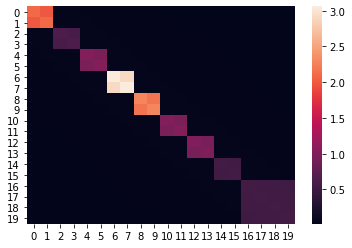

In [473]:
sns.heatmap(true_Sigma)

In [474]:
print(torch.max(covariates@true_beta))

tensor(0.0119)


In [475]:
print(torch.max(Y_sampled))

tensor(133)


In [476]:
torch.manual_seed(int(time.time()))
batch_size = 5
model = MC_PLNPCA(q,batch_size)
model.init_data(Y_sampled, O, covariates)
%time model.fit(2, 0.0001,0.1,0.1,C_optim = True)

MSE Sigma  0.22556577480625475
MSE beta :  1.0721475247676153
loss_beta :  tensor(-7.3490e-112, grad_fn=<NegBackward>)
loss_Sigma;  tensor(-2.6706e-133, grad_fn=<NegBackward>)
MSE Sigma  0.2176472926777304
MSE beta :  1.05530545386776
loss_beta :  tensor(-9.5494e-87, grad_fn=<NegBackward>)
loss_Sigma;  tensor(-3.4707e-103, grad_fn=<NegBackward>)
MSE Sigma  0.22742917792548295
MSE beta :  1.0536554191613248
loss_beta :  tensor(-1.7666e-99, grad_fn=<NegBackward>)
loss_Sigma;  tensor(-2.6496e-121, grad_fn=<NegBackward>)
MSE Sigma  0.23423742441713014
MSE beta :  1.0621543608715702
loss_beta :  tensor(-6.2440e-130, grad_fn=<NegBackward>)
loss_Sigma;  tensor(-1.5171e-141, grad_fn=<NegBackward>)
MSE Sigma  0.2465627495632003
MSE beta :  1.0886866349673539
loss_beta :  tensor(-9.0129e-87, grad_fn=<NegBackward>)
loss_Sigma;  tensor(-2.1617e-93, grad_fn=<NegBackward>)
MSE Sigma  0.236068779947637
MSE beta :  1.10131328279826
loss_beta :  tensor(-6.3823e-124, grad_fn=<NegBackward>)
loss_Sigma;  

MSE beta :  1.1681341667570408
loss_beta :  tensor(-1.3886e-90, grad_fn=<NegBackward>)
loss_Sigma;  tensor(-1.0579e-90, grad_fn=<NegBackward>)
MSE Sigma  0.11706429573324438
MSE beta :  1.1681872090623522
loss_beta :  tensor(-3.5070e-79, grad_fn=<NegBackward>)
loss_Sigma;  tensor(-2.9125e-79, grad_fn=<NegBackward>)
MSE Sigma  0.1173388581688226
MSE beta :  1.1682009096652384
loss_beta :  tensor(-3.0826e-101, grad_fn=<NegBackward>)
loss_Sigma;  tensor(-2.6230e-101, grad_fn=<NegBackward>)
MSE Sigma  0.11750689764218239
MSE beta :  1.168322567720899
loss_beta :  tensor(-3.8718e-118, grad_fn=<NegBackward>)
loss_Sigma;  tensor(-3.1250e-118, grad_fn=<NegBackward>)
MSE Sigma  0.11770093200256286
MSE beta :  1.1685237245428648
loss_beta :  tensor(-4.6395e-150, grad_fn=<NegBackward>)
loss_Sigma;  tensor(-2.6075e-150, grad_fn=<NegBackward>)
MSE Sigma  0.11810135765784142
MSE beta :  1.168474255794401
loss_beta :  tensor(-6.3599e-75, grad_fn=<NegBackward>)
loss_Sigma;  tensor(-6.0130e-75, grad_fn

<AxesSubplot:>

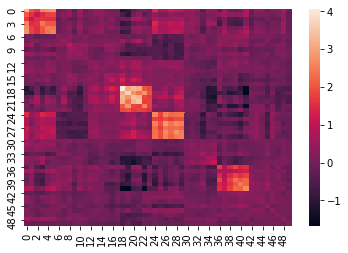

In [454]:
sns.heatmap(model.get_Sigma().detach().numpy())

<AxesSubplot:>

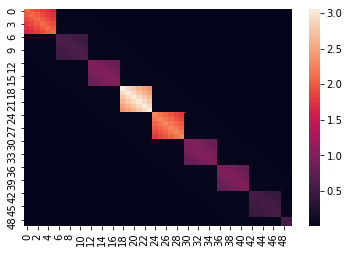

In [455]:
sns.heatmap(true_Sigma)

In [414]:
model.get_Sigma()

tensor([[ 1.5919,  1.4653,  1.3975,  ...,  0.0523,  0.1513,  0.0845],
        [ 1.4653,  1.3724,  1.3188,  ...,  0.0073,  0.1212,  0.0513],
        [ 1.3975,  1.3188,  1.2856,  ..., -0.0389,  0.0880,  0.0095],
        ...,
        [ 0.0523,  0.0073, -0.0389,  ...,  0.8697,  0.6853,  0.7058],
        [ 0.1513,  0.1212,  0.0880,  ...,  0.6853,  0.5577,  0.5608],
        [ 0.0845,  0.0513,  0.0095,  ...,  0.7058,  0.5608,  0.5871]],
       grad_fn=<MmBackward>)

In [413]:
true_Sigma

tensor([[2.1059, 2.0006, 1.9006,  ..., 0.0045, 0.0043, 0.0040],
        [2.1034, 2.0031, 1.9030,  ..., 0.0047, 0.0045, 0.0043],
        [2.1011, 2.0006, 1.9055,  ..., 0.0050, 0.0047, 0.0045],
        ...,
        [0.0045, 0.0047, 0.0050,  ..., 1.6170, 1.5361, 1.4593],
        [0.0043, 0.0045, 0.0047,  ..., 1.6145, 1.5386, 1.4617],
        [0.0040, 0.0043, 0.0045,  ..., 1.6121, 1.5361, 1.4642]])

In [191]:
model.beta

tensor([[-0.0224, -0.0648,  0.2322, -0.0565,  0.2007,  0.1496, -0.1741,  0.0774,
          0.1026,  0.1720, -0.1018,  0.0733,  0.0255, -0.0008,  0.1648,  0.0512,
          0.0007,  0.0959, -0.0435,  0.2044,  0.1561,  0.0928, -0.0796,  0.0966,
         -0.1068, -0.0393,  0.0171, -0.1143, -0.0653,  0.1510, -0.0907, -0.0745,
          0.0812,  0.1543,  0.3191, -0.0329,  0.0117, -0.2476,  0.0617,  0.0626,
         -0.1248, -0.1566, -0.0016, -0.0591, -0.0326, -0.1341,  0.1301,  0.0491,
          0.1655,  0.2150],
        [ 0.2058,  0.0979,  0.1655,  0.4085, -0.0024,  0.3002,  0.0918,  0.0158,
          0.0314, -0.0790,  0.1559,  0.1129,  0.0203, -0.0432, -0.1270,  0.2124,
          0.1088, -0.1736,  0.0283,  0.1422,  0.0921,  0.0490,  0.0322,  0.0548,
         -0.0036, -0.0447,  0.0938,  0.2520, -0.3129,  0.0265,  0.0545,  0.0692,
          0.1205,  0.1318,  0.0331, -0.0601, -0.0641,  0.1256,  0.0591,  0.0618,
         -0.0393, -0.0963, -0.0185, -0.2947, -0.0857, -0.1736,  0.1096,  0.0468,


In [192]:
true_beta

tensor([[-0.0237, -0.1394,  0.2144, -0.0596,  0.1708,  0.1546, -0.0580,  0.0305,
          0.0673,  0.1377, -0.1620,  0.0359, -0.0199,  0.0257,  0.0807,  0.0286,
         -0.1005,  0.0185, -0.0578,  0.1322,  0.2489,  0.0642, -0.0408,  0.0875,
         -0.0384,  0.0763, -0.0292, -0.1030, -0.0884,  0.1484, -0.0787, -0.0588,
          0.0731,  0.1313,  0.1439, -0.0207, -0.0474, -0.1664,  0.0339,  0.0170,
         -0.0660, -0.1478,  0.0863, -0.0490, -0.0255, -0.1836,  0.0216,  0.0421,
          0.0359, -0.0672],
        [-0.0819,  0.0110, -0.0940,  0.1822, -0.1549,  0.1019, -0.0537, -0.0547,
         -0.1119, -0.1093,  0.1268, -0.0076, -0.0549, -0.1772, -0.2342,  0.1171,
          0.0027, -0.1536,  0.0128,  0.0200, -0.0291,  0.0901, -0.0007,  0.0192,
         -0.0225, -0.0580,  0.0505,  0.0117, -0.2717,  0.1360, -0.0084,  0.0495,
          0.0846,  0.0283, -0.0207, -0.0486,  0.0099,  0.1378,  0.0999, -0.0008,
         -0.0540,  0.0271,  0.0178, -0.2330, -0.1096,  0.0083,  0.0981,  0.0635,


In [226]:
batch_size = 5
model = MC_PLNPCA(q,batch_size)
model.init_data(Y_sampled, O, covariates)

torch.manual_seed(int(time.time()))
for Y_b, covariates_b, O_b in model.get_batch(model.batch_size): 
    print('Y_b : ', Y_b)
    W = torch.randn(5, model.batch_size,q)
    model.check_batch(Y_b, covariates_b, O_b,W)
    

Y_b :  tensor([[  0,   0,  11,   0,   0],
        [  2,   0,   1,   0,   0],
        [  1,   1,   2,   0,   0],
        [  2,   0,   2,   3,   1],
        [  8,   0,   2, 136,  73]])
loss :  tensor(5.9508e-281, grad_fn=<MeanBackward0>)
diff :  tensor(0., grad_fn=<CopyBackwards>)
my_grad :  tensor([[-2.8157e-280, -1.1190e-280, -1.9145e-280],
        [-6.2642e-281, -1.7611e-281,  1.7572e-280],
        [-1.7002e-280,  5.4231e-280,  8.3324e-280],
        [-7.8557e-279,  3.0020e-280, -4.6934e-279],
        [-3.8433e-279,  8.9527e-281, -2.2005e-279]], grad_fn=<MeanBackward1>)
true :  tensor([[-2.8157e-280, -1.1190e-280, -1.9145e-280],
        [-6.2642e-281, -1.7611e-281,  1.7572e-280],
        [-1.7002e-280,  5.4231e-280,  8.3324e-280],
        [-7.8557e-279,  3.0020e-280, -4.6934e-279],
        [-3.8433e-279,  8.9527e-281, -2.2005e-279]])
Y_b :  tensor([[33,  1,  1,  5,  4],
        [ 5, 14,  0,  1,  1],
        [ 9,  5,  1,  0,  0],
        [ 0,  1,  3,  3,  6],
        [ 0,  1,  0,  0,  1

In [234]:
batch_size = 1
model = MC_PLNPCA(q,batch_size)
model.init_data(Y_sampled, O, covariates)
model.fit_all(0.1,0.1,N_iter = 50, acc = 0.01)
#model.compute_likelihood(0.0001)
#model.fit(10,0.001, lr_beta = 0.1,lr_C = 0.1, C_optim = False)

---------------------MSE Sigma:  5.654197074345726
MSE beta :  1.6826883721366408
likelihood-------------------------------------- tensor(0., grad_fn=<MulBackward0>)
---------------------MSE Sigma:  5.654197074345726
MSE beta :  1.6826883721366408
likelihood-------------------------------------- tensor(0., grad_fn=<MulBackward0>)
---------------------MSE Sigma:  5.654197074345726
MSE beta :  1.6826883721366408
likelihood-------------------------------------- tensor(0., grad_fn=<MulBackward0>)
---------------------MSE Sigma:  5.654197074345726
MSE beta :  1.6826883721366408
likelihood-------------------------------------- tensor(0., grad_fn=<MulBackward0>)
---------------------MSE Sigma:  5.654197074345726
MSE beta :  1.6826883721366408
likelihood-------------------------------------- tensor(0., grad_fn=<MulBackward0>)
---------------------MSE Sigma:  5.654197074345726
MSE beta :  1.6826883721366408
likelihood-------------------------------------- tensor(0., grad_fn=<MulBackward0>)
----

likelihood-------------------------------------- tensor(0., grad_fn=<MulBackward0>)


$$
\nabla_{\beta} p_{\theta}\left(Y \mid W_k\right)=p_{\theta}\left(Y \mid W_k\right)\left[-X^{\top} \exp \left(0+X\beta+W_k^{\top} C^{\top}\right)+ X^{\top}Y\right]
$$

$$
\nabla_{C} p_{\theta}\left(Y \mid W_k\right)=p_{\theta}\left(Y \mid W_k\right)\left[Y-\exp \left(0+X \beta+W_k^{\top} C^{\top} \right)\right]
^{\top}W_k 
$$

$$
\begin{aligned}
P_{\theta}\left(Y_{i} \mid W_{i,k}\right) &=\prod_{j=1}^{p} p_{\theta}\left(Y_{i j} \mid W_{i,k}\right) \\
&=\prod_{j=1}^{P} \frac{1}{Y_{i j} !} \exp \left(-\exp \left(o_{i j}+z_{i j}\right)\right) \exp \left(o_{i j}+z_{i j}\right)^{Y_{ij}}
\end{aligned}
$$
$$
Z_{i j}=x_{i}^{\top} \beta_{j}+W_{i,k}^{\top} C^{\top} _{j}
$$




In [ ]:
 '''   def compute_single_log_like(self, i, acc):
        N_iter = int(1/acc)
        E = 0 
        for _ in range(N_iter): 
            W = np.random.randn(q)
            E -= 1/2*SLA.norm(W)**2
            E -= np.sum(np.exp(self.O[i,:]+self.beta.T@self.covariates[i,:]+ self.C@W)) 
            E+= np.sum((self.O[i,:]+self.beta.T@self.covariates[i,:]+ self.C@W)*self.Y[i,:])
            #print('E : ', E)
        E/= N_iter
        return E
    
    def batch_log_like(self,acc): 
        batch_E = 0
        for i in range(10): 
            batch_E += self.compute_single_log_like(i,acc) 
        return batch_E
    
    def single_grad_beta_log_like(self,i, acc): 
        N_iter = int(1/acc)
        grad = 0
        for _ in range(N_iter): 
            W = np.random.randn(q)
            grad += self.covariates[i,:].T.reshape(-1,1)@(np.exp(self.O[i,:]+ self.covariates[i,:]@self.beta+self.C@W)).reshape(1,-1)
            grad += self.covariates[i,:].T.reshape(-1,1)@(self.Y[i,:].reshape(1,-1))
        return grad/N_iter
'''
'''
fonctions pour tester les gradients avec des W que l'on simule qu'une seule fois 
    def batch_grad_beta(self, acc): 
        batch_grad = 0
        for i in range(10): 
            batch_grad += self.single_grad_beta_log_like(i,acc) 
        return batch_grad
        
        def single_likelihood(self,i,W): 
            ## W should be an array of size q 
            

        Y_i = self.Y[i,:]
        x_i = self.covariates[i,:]
        O_i = self.O[i,:]

        norm_W = TLA.norm(W)**2
        log_fact = -torch.sum(log_stirling(Y_i))
        Z_i = x_i@self.beta + W@(self.C.T)
        exp_term = -torch.sum(torch.exp(O_i +Z_i))
        data_term = torch.sum(Y_i*(O_i+Z_i))
        return torch.exp(log_fact + exp_term + data_term-1/2*norm_W)
            
    def single_grad_beta(self,i,W): 
        likeli = self.single_likelihood(i,W)
        Y_i = self.Y[i,:]
        x_i = self.covariates[i,:].reshape(1,-1)
        O_i = self.O[i,:]
        exp = torch.exp(O_i + x_i@self.beta + W@(self.C.T))
        return likeli*(x_i.T@(-exp+Y_i))
    
    def single_fit(self,i,W): 
        loss = self.single_likelihood(i,W)
        loss.backward()
        print('error : ', torch.norm(self.beta.grad-self.single_grad_beta(i,W)))
    def batch_likelihood_test(self,Y_b,covariates_b, O_b, W): 
        norm_W = torch.sum(torch.norm(W, dim = 1)**2)
        log_fact = torch.sum(log_stirling(Y_b))
        Z_b = covariates_b@self.beta + W@(self.C.T)
        exp_term = -torch.sum(torch.exp(O_b+Z_b))
        data_term = torch.sum(Y_b * (O_b + Z_b))
        return torch.exp(-log_fact-norm_W/2 +exp_term + data_term)
    
    def batch_grad_beta_test(self,Y_b,covariates_b, O_b, W): 
        likelihood =  self.batch_likelihood_test(Y_b,covariates_b, O_b, W)
        Z_b = O_b + covariates_b@self.beta + W@(self.C.T)
        return likelihood*(covariates_b.T@(-torch.exp(Z_b)+Y_b))
        
   '''
        

In [27]:
class MC_PLNPCA_bis(): 
    
    def __init__(self,q, batch_size): 
        self.q = q
        self.batch_size = batch_size 
        pass
    
    def init_data(self, Y,O,covariates): 
        '''
        Initialise some usefuls variables given the data. 
        We also initialise C and beta. 
        '''
        
        self.Y = Y 
        self.covariates = covariates 
        self.O = O 
        self.n = Y.shape[0] 
        self.p = Y.shape[1]
        self.d = self.covariates.shape[1]
        noise = torch.randn(self.p) 
        self.Sigma =  (torch.diag(noise**2)+ 1e-1)
        self.C = torch.clone(torch.from_numpy(C_from_Sigma(self.Sigma,self.q)))
        #self.C = torch.clone(true_C)
        self.C.requires_grad_(True)
        self.beta = torch.randn(self.d,self.p)
        #self.beta = torch.clone(true_beta)
        self.beta.requires_grad_(True)
        
        
    
    def single_likelihood_test(self,i,acc): 
        '''
        computes the likelihood of a single point. Useless since We can compute it efficiently
        with batch_likelihood(). This is more a beta version. 
        '''
        N_iter = int(1/acc)
        Y_i = self.Y[i,:]
        x_i = self.covariates[i,:]
        O_i = self.O[i,:]
        E = 0
        for _ in range(N_iter):
            W = torch.randn(self.q)
            log_fact = torch.sum(log_stirling(Y_i))
            norm_W = 1/2*torch.norm(W)**2
            poiss_like = - torch.sum(torch.exp(self.O[i,:]+self.beta.T@self.covariates[i,:]+ self.C@W)) 
            poiss_like += torch.sum((self.O[i,:]+self.beta.T@self.covariates[i,:]+ self.C@W)*self.Y[i,:])
            E+= torch.exp(-log_fact -norm_W + poiss_like)
        return E/N_iter 
    def get_Sigma(self):
        '''
        simple function to get Sigma
        '''
        return self.C@(self.C.T)
    



    def get_batch(self,batch_size): 
        '''
        get the batches required to do a  minibatch gradient ascent.  
        
        args : 
                'batch_size' int.  the batch size you want. 
                
        returns : a generator. Will generate n/batch_size samples of size batch_size (except the last one 
                    since the rest of the division is not always an integer)
                    
        '''
        np.random.seed(0)
        indices = np.arange(self.n)
        np.random.shuffle(indices)
        self.batch_size = batch_size 
        nb_full_batch, last_batch_size  = self.n//self.batch_size, self.n % self.batch_size  
        for i in range(nb_full_batch): 
            yield   (self.Y[indices[i*self.batch_size: (i+1)*self.batch_size]], 
                    self.covariates[indices[i*self.batch_size: (i+1)*self.batch_size]],
                    self.O[indices[i*self.batch_size: (i+1)*self.batch_size]]) 
                        
                  
        if last_batch_size != 0 : 
            self.batch_size = last_batch_size
            yield   (self.Y[indices[-last_batch_size:]], 
                    self.covariates[indices[-last_batch_size:]],
                    self.O[indices[-last_batch_size:]])
        
    def compute_likelihood(self, acc): 
        likelihood = 0
        N_samples = int(1/acc)
        W = torch.randn(N_samples, self.n, self.q)
        likelihood +=  self.batch_likelihood(self.Y,self.covariates, self.O,W)
        return likelihood/self.n
    
    
    
    
    def batch_grad_beta(self,Y_b,covariates_b, O_b,W): 
        grad = 0
        log_like = torch.sum(self.batch_likelihood(Y_b,covariates_b, O_b,W, somme = False), axis = 1)
        first_term = -torch.exp(O_b +covariates_b@self.beta + W@(self.C.T))
        second_term = Y_b
        grad =  torch.sum(torch.multiply(log_like.reshape(-1,1,1),((covariates_b.T)@(first_term + second_term))), axis = 0)
        # the for loop here does the same, just a sanity check
        '''
        grad = 0
        for k in range(N_samples): 
            log_like = self.batch_likelihood(Y_b,covariates_b, O_b,W[k])#/N_samples
            exp_term  = -torch.exp(O_b +covariates_b@self.beta + W[k]@(self.C.T))
            grad +=  log_like*(covariates_b.T)@(exp_term + Y_b)
        '''
        return grad/W.shape[0]
    
    
    def batch_grad_C(self,Y_b,covariates_b, O_b,W): 
        grad = 0 
        for k in range(W.shape[0]):
            log_like = self.batch_likelihood(Y_b,covariates_b, O_b,W[k], somme = True)
            exp_term  = -torch.exp(O_b +covariates_b@self.beta + W[k]@(self.C.T))
            grad +=  log_like*((exp_term + 0*Y_b).T@W[k])
        return grad/W.shape[0]
            
    def fit(self, N_iter, acc): 
        optim_beta = torch.optim.Rprop([self.beta], lr = 0.3)
        optim_C = torch.optim.Rprop([self.C], lr = 0.3)
        N_samples = int(1/acc)
        for i in range(N_iter):
            for Y_b, covariates_b, O_b in self.get_batch(self.batch_size):
                W = torch.randn(N_samples,self.batch_size, self.q) 
                if False : 
                    optim_C.zero_grad()
                    #print('MSE Sigma: ', torch.mean((self.get_Sigma()-true_Sigma)**2).item())
                    grad_C = self.batch_grad_C(Y_b, covariates_b, O_b,W)
                    loss = -self.batch_likelihood(Y_b,covariates_b, O_b,W)
                    loss.backward()
                    #self.C.grad =  -grad_C/torch.norm(grad_C)
                    print('loss : ', loss.item())
                    optim_C.step()
                else : 
                    optim_beta.zero_grad()
                    print('MSE beta : ', torch.mean((self.beta-true_beta)**2).item())
                    grad_beta = self.batch_grad_beta(Y_b,covariates_b, O_b,W)
                    loss = -self.batch_likelihood(Y_b,covariates_b, O_b,W)
                    loss.backward()
                    self.beta.grad = -grad_beta/torch.mean(torch.abs(grad_beta))
                    optim_beta.step()
            print('----------------------------------------------------------------------new_epoch')
            
            
    def batch_likelihood(self,Y_batch,covariates_batch, O_batch, W, somme = True ): 
        '''
        computes the approximation of the likelihood of a batch. 
        
        args : 
                'Y_batch' : tensor of size(batch_size, p)
                'covariates_batch' : tensor of size(batch_size, d)
                'O_batch' : tensor of size(batch_size, p)
                'acc' : float. the accuracy you want. The lower the accuracy, the lower the algorithm. 
                        we will sampThe size of tensor a (1000) must match the size of tensor b (20) at non-singleton dimension 2les 1/acc times. 
        returns : 
                the approximation of the likelihood. 
        ''' 
    
        last_dim = len(W.shape)-1
        if last_dim >1 : 
            N_samples = W.shape[0] # number of samples of W 
        else : N_samples = 1
        #N_samples = W.shape[0]
        Z = covariates_batch@self.beta + W@(self.C.T)
        norm_W = TLA.norm(W, dim = last_dim)**2
        log_fact =  torch.sum(log_stirling(Y_batch), axis = 1) # the factorial term 
        poiss_like =  - torch.sum(torch.exp(O_batch+Z), axis = last_dim) # first term of the poisson likelihood
                                                                         #the normalising term with the exponential 
        poiss_like += torch.sum((O_batch+Z)*Y_batch, axis = last_dim)    # second term of the poisson likelihood
        
            
        if somme : 
            # If we want the true likelihood
            # We first take the exponential of the sum of the logs and then divide by the Number of samples we took.  
            return torch.sum(torch.exp(-log_fact -1/2*norm_W+poiss_like))/N_samples 
        #for some purposes, we may want only the exponential and not the sum
        else : return torch.exp(-log_fact -1/2*norm_W+poiss_like)/N_samples

In [28]:
model_bis = MC_PLNPCA_bis(q,n//2) 
model_bis.init_data(Y_sampled, O,covariates )
model_bis.fit(20,0.01)

MSE beta :  1.9102846328682492
MSE beta :  1.8096150648046705
----------------------------------------------------------------------new_epoch
MSE beta :  1.8552132061091728
MSE beta :  1.9129760878867497
----------------------------------------------------------------------new_epoch
MSE beta :  2.0701245395137264
MSE beta :  2.3871577710512315
----------------------------------------------------------------------new_epoch
MSE beta :  2.6920821053624366
MSE beta :  3.339558541508027
----------------------------------------------------------------------new_epoch
MSE beta :  4.266740013933548
MSE beta :  5.829849607680941
----------------------------------------------------------------------new_epoch
MSE beta :  8.225635687097924
MSE beta :  9.993858093434689
----------------------------------------------------------------------new_epoch
MSE beta :  13.342151645474365
MSE beta :  14.396301048193923
----------------------------------------------------------------------new_epoch
MSE beta : 

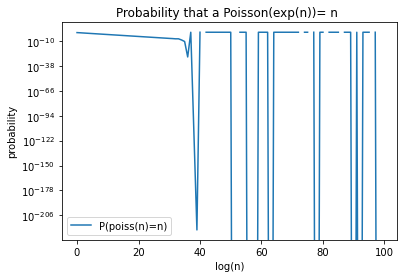

In [102]:
def proba_mean(mean_):
    mean = torch.Tensor([mean_])
    k = torch.Tensor([int(mean)])
    log_fact = -log_stirling(torch.Tensor([k]))
    exp_term = - mean
    data_term = k*torch.log(mean)
    somme = log_fact + exp_term + data_term 
    #print('somme ', somme)
    #print('result : ', torch.exp(somme))
    return torch.exp(somme)

for i in range(60): 
    pass
    #print('proab', proba_mean(np.exp(i)))

length = 100
prob = [proba_mean(np.exp(i)).numpy() for i in range(length)]

fig= plt.figure()
plt.plot(np.arange(length),prob, label = 'P(poiss(n)=n)')
plt.yscale('log')
plt.ylabel('probability')
plt.xlabel('log(n)')
plt.title('Probability that a Poisson(exp(n))= n ')
plt.legend()
#plt.savefig('poisson distribution')



In [65]:
def poiss_density(mean, k ): 
    return 1/factorial(k)*np.exp(-mean)*mean**k

#print([poiss_density(i,i) for i in range(70)])
    

[1.0, 0.36787944117144233, 0.2706705664732254, 0.22404180765538773, 0.19536681481316456, 0.17546736976785068, 0.16062314104798003, 0.1490027796743379, 0.13958653195059692, 0.1317556400095227, 0.1251100357211333, 0.1193780602280255, 0.11436791550944654, 0.10993981424841086, 0.10598914793051553, 0.10243586666453418, 0.09921753162215582, 0.09628462779844535, 0.09359731648870141, 0.09112313246841229, 0.08883531739208522, 0.08671159160336754, 0.0847332342752624, 0.08288438439146861, 0.0811515025272517, 0.07952295146806547, 0.07798866585178797, 0.07653988933052164, 0.07516896352687369, 0.07386915713933492, 0.07263452647159147, 0.07145980077773666, 0.07034028736850317, 0.06927179257562581, 0.06825055553466172, 0.06727319239963175, 0.06633664910130228, 0.06543816114459435, 0.06457521923824946, 0.06374553978250255, 0.06294703942359217, 0.062177813028978145, 0.061436114552760206, 0.06072034035351376, 0.06002901460152964, 0.05936077647306704, 0.058714368878625516, 0.058088628512689325, 0.05748247

In [50]:
int(1)

1